In [1]:
#Import de Tensor et vérification de la version
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import tensorflow as tf
from pymongo import MongoClient


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow import keras
from tensorflow.keras import layers

from keras.datasets import mnist



In [2]:
# Connexion à la base de données MongoDB
client = MongoClient("mongodb://localhost:27017")
db = client["DigitRecognizer"]
train_collection_name = "train"
test_collection_name = "test"
drawings_collection_name = "drawings"


# Récupération des données d'entraînement et de test
train_cursor = db[train_collection_name].find()
test_cursor = db[test_collection_name].find()
drawings_cursor = db[drawings_collection_name].find()


# Conversion des données en DataFrames pandas
train_data = pd.DataFrame(list(train_cursor), columns=["label"] + [f"pixel{i}" for i in range(784)])

test_data = pd.DataFrame(list(test_cursor), columns=[f"pixel{i}" for i in range(784)])

drawings_data = pd.DataFrame(list(drawings_cursor), columns=["prediction"] + ["pixels"])




#Ferme la connexion à Mongo
client.close()



In [3]:
# Diviser les données en features (X) et labels (y)
X = train_data.drop("label", axis=1)
y = train_data["label"]

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir les séries pandas en tableaux NumPy
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# Normaliser les données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialiser le modèle
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(784,)),
    layers.Dense(10, activation='softmax')
])

# Compiler le modèle avec l'optimiseur Adam
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Évaluer le modèle sur l'ensemble de test
accuracy = model.evaluate(X_test, y_test)[1]
print(f"Précision du modèle : {accuracy}")


Epoch 1/10
1050/1050 [==============================] - 7s 6ms/step - loss: 0.2882 - accuracy: 0.9176 - val_loss: 0.1901 - val_accuracy: 0.9485
Epoch 2/10
1050/1050 [==============================] - 5s 5ms/step - loss: 0.1128 - accuracy: 0.9657 - val_loss: 0.1843 - val_accuracy: 0.9540
Epoch 3/10
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0792 - accuracy: 0.9769 - val_loss: 0.1677 - val_accuracy: 0.9600
Epoch 4/10
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0522 - accuracy: 0.9836 - val_loss: 0.1625 - val_accuracy: 0.9620
Epoch 5/10
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0376 - accuracy: 0.9885 - val_loss: 0.1609 - val_accuracy: 0.9644
Epoch 6/10
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0296 - accuracy: 0.9904 - val_loss: 0.1864 - val_accuracy: 0.9669
Epoch 7/10
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0283 - accuracy: 0.9919 - val_loss: 0.1917 - val_accuracy:

In [4]:
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")


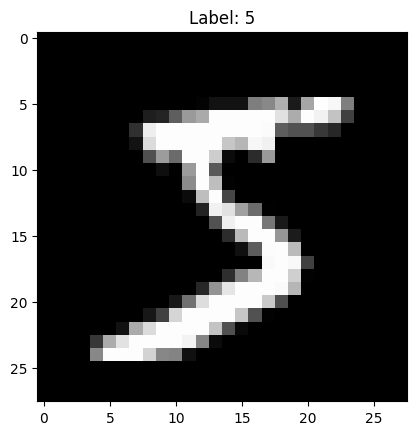

In [5]:
#Question guidées:
# 1) Charger et visualiser les images d'entraînement et de test du jeu de données MNIST dans un notebook ?


# Charger les données d'entraînement et de test
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# a. Afficher une image quelconque depuis le train en indiquant comme titre de l'image son label (càd le target associé) ?
plt.imshow(X_train[0], cmap='gray')  # Vous pouvez choisir un autre index si vous le souhaitez
plt.title(f"Label: {y_train[0]}")
plt.show()


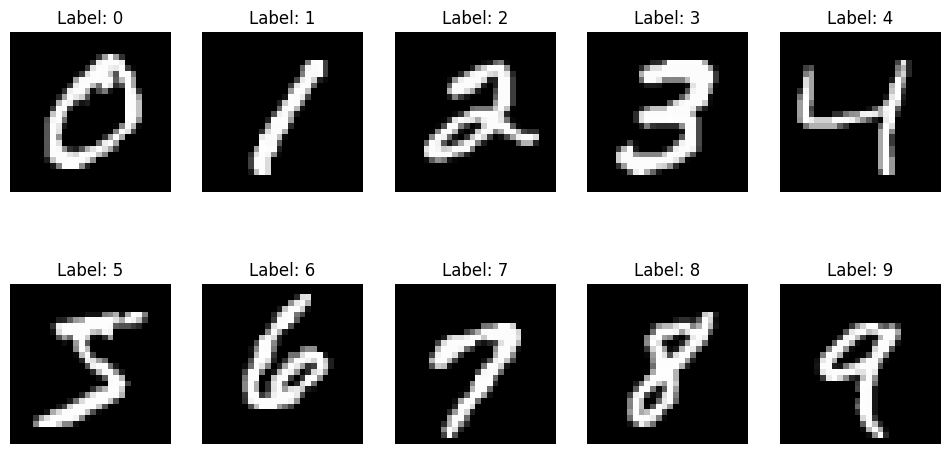

In [6]:

# b. Afficher dans une même figure les chiffres de 0 à 9 ?
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[y_train == i][0], cmap='gray')
    plt.title(f"Label: {i}")
    plt.axis('off')  # Masquer les axes
plt.show()


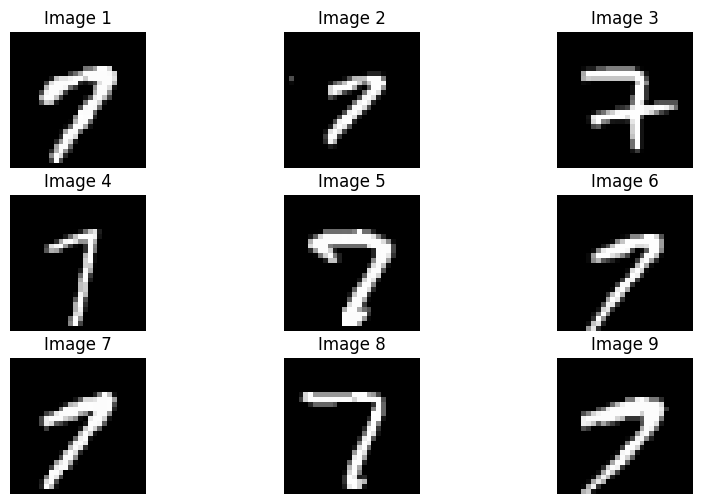

In [7]:
# c. Pour visualiser les différentes façons d'écrire un 7, afficher les 9 1ères images qui correspondent au chiffre 7 en les plaçant dans une même figure ?

# Sélectionner les indices des images où le label est égal à 7
indices_7 = (y_train == 7)
images_7 = X_train[indices_7][:9]

# Afficher les 9 premières images du chiffre 7
plt.figure(figsize=(10, 6))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_7[i], cmap='gray')
    plt.title(f"Image {i + 1}")
    plt.axis('off')  # Masquer les axes

plt.show()

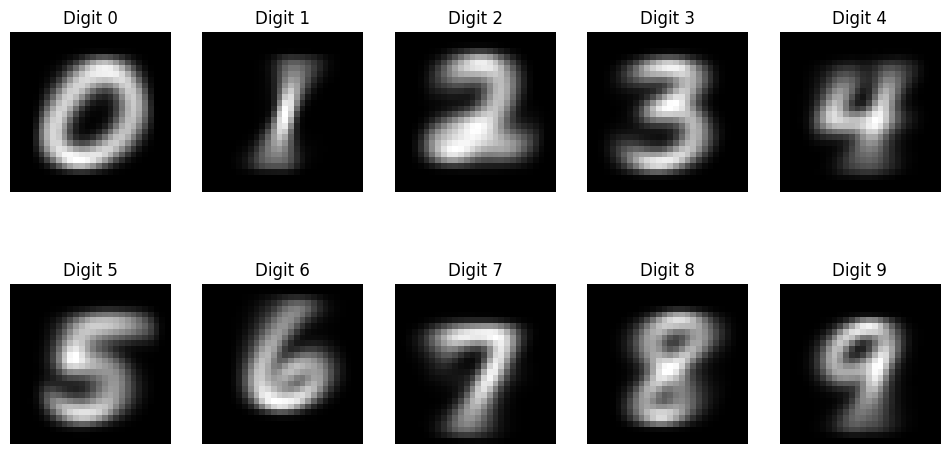

In [8]:
# d. Afficher le représentant "moyen" de chaque chiffre ?

# Calculer le représentant moyen de chaque chiffre
average_digits = []
for digit in range(10):
    indices_digit = (y_train == digit)
    images_digit = X_train[indices_digit]
    average_digit = np.mean(images_digit, axis=0)
    average_digits.append(average_digit)

# Afficher le représentant moyen de chaque chiffre
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(average_digits[i], cmap='gray')
    plt.title(f"Digit {i}")
    plt.axis('off')

plt.show()

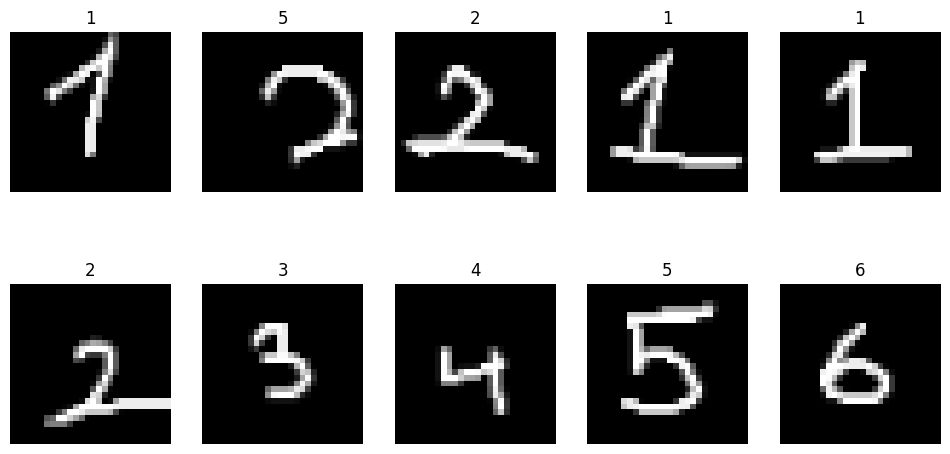

In [10]:
#Affichage des dessins des utilisateurs
plt.figure(figsize=(12, 6))
num_drawings_to_display = min(10, len(drawings_data))  # Assurez-vous de ne pas dépasser la taille du DataFrame

for i in range(num_drawings_to_display):
    plt.subplot(2, 5, i + 1)
    
    # Extraction des pixels du dessin depuis la colonne "pixels"
    pixels = drawings_data["pixels"].iloc[i]  # Utilisez "iloc" pour accéder à la ligne par son indice
    pixels_array = np.array(pixels).reshape(28, 28)
    
    # Affichage de l'image
    plt.imshow(pixels_array, cmap='gray')

    # Affichage des étiquettes (true et prédite)
    predicted_label = drawings_data["prediction"].iloc[i]
    plt.title(predicted_label)
    plt.axis('off')

plt.show()
